In [348]:
import pickle
import numpy as np 
import pandas as pd
import seaborn as sns
import re
from catboost import CatBoostClassifier, Pool
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ndcg_score
from sklearn.model_selection import GroupShuffleSplit
import time
from spellchecker import SpellChecker
from nltk.corpus import stopwords as nltk_stopwords

In [386]:
df = pd.read_csv('dataset_train.csv', encoding='utf-8')

In [387]:
df = df.drop(['text', 'comments'], axis=1)

# Создадим бинарную метку 
Все комментарии со значением score 0,1,2 переведем в 1.
Все комментарии со значением score 3,4 переведем в 0.
Будем предсказывать относится комментарий к классу 1 или 0.


In [388]:
def create_score(x):
    if x in [0,1,2]:
        return 1
    else:
        return 0

In [389]:
# создание бинарного скора
df['score_bin'] = df['score'].apply(create_score)

In [390]:
# Создание столбца групп для перемешивания датасета и 
# отслеживания пренадлежности комментариев к определенному посту
group = []
for k in range(df.shape[0]//5):
    group += [k]*5
df['group'] = np.array(group)

In [391]:
gss = GroupShuffleSplit(test_size=0.30, n_splits=1, random_state = 7).split(df, groups=df['group'])

In [392]:
# Создаем индексы для разделения датасета на обучающую и тестовую
X_train_inds, X_test_inds = next(gss) 

In [393]:
df_train= df.iloc[X_train_inds]
df_train = df_train.sample(frac=1)
features_train = df_train.loc[:, ~df_train.columns.isin(['group', 'score', 'score_bin'])]
target_train = df_train.loc[:, df_train.columns.isin(['score_bin'])]

df_test = df.iloc[X_test_inds]
features_test = df_test.loc[:, ~df_test.columns.isin(['group', 'score', 'score_bin'])]
target_test = df_test.loc[:, df_test.columns.isin(['score_bin'])]
target_test_rank = df_test.loc[:, df_test.columns.isin(['score'])]

#  Создание модели и обучение

In [394]:
model_CatBoost = CatBoostClassifier(loss_function='Logloss',
                                    verbose=True)

In [395]:
print(f'Size features_train:{features_train.shape}\nSize target_train:{target_train.shape}')

Size features_train:(308370, 14)
Size target_train:(308370, 1)


In [396]:
start = time.time()
model_CatBoost.fit(features_train, target_train)
end = time.time()
print("The time of execution of above program is :", (end-start))

Learning rate set to 0.119061
0:	learn: 0.6799830	total: 198ms	remaining: 3m 17s
1:	learn: 0.6695872	total: 395ms	remaining: 3m 17s
2:	learn: 0.6615675	total: 590ms	remaining: 3m 16s
3:	learn: 0.6551969	total: 787ms	remaining: 3m 16s
4:	learn: 0.6504806	total: 980ms	remaining: 3m 14s
5:	learn: 0.6466605	total: 1.17s	remaining: 3m 14s
6:	learn: 0.6437459	total: 1.37s	remaining: 3m 14s
7:	learn: 0.6414581	total: 1.56s	remaining: 3m 13s
8:	learn: 0.6396843	total: 1.78s	remaining: 3m 15s
9:	learn: 0.6382551	total: 1.98s	remaining: 3m 15s
10:	learn: 0.6369782	total: 2.18s	remaining: 3m 15s
11:	learn: 0.6360622	total: 2.37s	remaining: 3m 15s
12:	learn: 0.6353301	total: 2.56s	remaining: 3m 14s
13:	learn: 0.6347785	total: 2.75s	remaining: 3m 14s
14:	learn: 0.6343178	total: 2.95s	remaining: 3m 13s
15:	learn: 0.6339066	total: 3.14s	remaining: 3m 13s
16:	learn: 0.6335687	total: 3.34s	remaining: 3m 13s
17:	learn: 0.6332984	total: 3.53s	remaining: 3m 12s
18:	learn: 0.6330605	total: 3.73s	remaining:

In [397]:
model_CatBoost.get_feature_importance(prettified=True)

,Feature Id,Importances
0,letters_num,13.165841
1,punct_num,10.088516
2,positive,9.336903
3,cos_sim,9.052203
4,words_mean_len,8.116466
5,stopwords_percent_num,6.876762
6,first_capital_num,6.557746
7,unique_percent_num,6.440198
8,unique_num,5.761783
9,words_num,5.697507


In [398]:
predictions = model_CatBoost.predict_proba(features_test)[:, 1]

In [399]:
predictions

array([0.55167444, 0.47470936, 0.55684308, ..., 0.55071211, 0.51288932,
       0.21699549])

# Перевести вероятности в числа (0, 1, 2, 3, 4)

In [400]:
probabilities = np.reshape(predictions, (-1, 5))

In [401]:
# Алгоритм для перевода вероятности в числа (0, 1, 2, 3, 4)
num = len(probabilities)
k = [[0]*5 for i in range(num)]
for i in range(num):
    for j in range(4):
        for l in range(1, 5-j):
            if probabilities[i][j] < probabilities[i][j+l]:
                k[i][j] += 1
            else:
                k[i][j+l] += 1

In [402]:
y_res = np.reshape(np.array(k), (-1, 5))

In [403]:
y = np.reshape(np.array(target_test_rank), (-1, 5))

# Рассчет метрики ndcg

In [404]:
from sklearn.metrics import ndcg_score

In [405]:
ndcg_score(y, y_res)

0.8823169932905679

In [406]:
importance = model_CatBoost.get_feature_importance(prettified=True)

<AxesSubplot:xlabel='Importances', ylabel='Feature Id'>

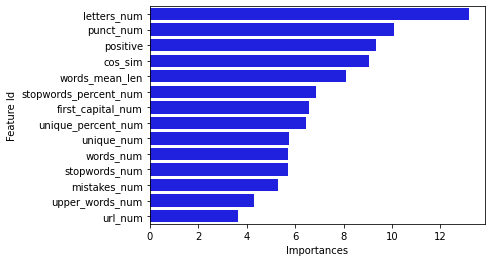

In [407]:
sns.barplot(
    x='Importances', 
    y='Feature Id', 
    data=importance, 
    color='blue')